<a href="https://colab.research.google.com/github/shafi-21/DataAnalysis/blob/main/Theme_vs_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install pyspark pandas numpy seaborn matplotlib

distutils: c:\users\user\appdata\local\programs\python\python37\Include\UNKNOWN
sysconfig: c:\users\user\appdata\local\programs\python\python37\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\user\appdata\local\programs\python\python37\Include\UNKNOWN
sysconfig: c:\users\user\appdata\local\programs\python\python37\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


# Data Preprocessing

In [ ]:
# Import the pandas library
import pandas as pd

# Read the data from the dataset
store_data = pd.read_csv("../Dataset/zomato.csv", dtype='unicode')

In [ ]:
store_data.drop_duplicates(subset=['name'],inplace=True)

# Analysis

In [ ]:
data = store_data[['cuisines','rate','votes']]
data.head()
frame = data.copy()
frame['rate']=frame['rate'].str.replace('/5','')
def is_number(s):
    try:
        return float(s)
    except ValueError:
        return 'NaN'
frame.rate = frame.rate.apply(lambda x: is_number(x) )
frame.dropna(subset = ["cuisines","rate","votes"], inplace=True)

frame.rate = frame.rate.astype(float)
frame.votes = frame.votes.astype(int)

In [ ]:
# Calculate mean of vote. Average column
mean = frame['rate'].mean()
print(mean)
m = frame['votes'].quantile(0.90)

3.6224644549763028


In [ ]:
# Function that computes the weighted rating of each restaurant
def weighted_rating(x, m=m, C=mean):
    v = x['votes']
    R = x['rate']
    # Calculation is based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature called 'score' and calculate its value
frame['score'] = frame.apply(weighted_rating, axis=1)

# Sort restaurants based on score calculated
frame = frame.sort_values('score', ascending=False)

frame['score'] = frame['score'].round(1)

In [ ]:
split_frame = frame.assign(cuisines=frame['cuisines'].str.split(',')).explode('cuisines')
split_frame.dropna(subset = ["cuisines","rate","votes"], inplace=True)
split_frame

,cuisines,rate,votes,score
0,North Indian,4.1,775,3.9
0,Mughlai,4.1,775,3.9
0,Chinese,4.1,775,3.9
1,Chinese,4.1,787,3.9
1,North Indian,4.1,787,3.9
...,...,...,...,...
51614,Arabian,3.2,5,3.6
51614,Momos,3.2,5,3.6
51632,North Indian,3.3,4,3.6
51632,Kerala,3.3,4,3.6


In [ ]:
split_frame.cuisines = split_frame.cuisines.apply(lambda x: x.strip())
split_frame.cuisines


0        North Indian
0             Mughlai
0             Chinese
1             Chinese
1        North Indian
             ...     
51614         Arabian
51614           Momos
51632    North Indian
51632          Kerala
51632         Chinese
Name: cuisines, Length: 15412, dtype: object

In [ ]:
# Filter out all qualified restuarants into a new DataFrame
q_restaurants = split_frame.copy().loc[split_frame['votes'] >= m]
q_restaurants

,cuisines,rate,votes,score
0,North Indian,4.1,775,3.9
0,Mughlai,4.1,775,3.9
0,Chinese,4.1,775,3.9
1,Chinese,4.1,787,3.9
1,North Indian,4.1,787,3.9
...,...,...,...,...
51078,Mediterranean,4.3,654,4.0
51078,Salad,4.3,654,4.0
51089,Continental,4.1,1003,3.9
51089,North Indian,4.1,1003,3.9


In [ ]:
temp = q_restaurants.groupby('cuisines').size().reset_index(name='count')
list_of_cuisines = temp[temp['count'] > 50].cuisines.tolist()
q_restaurants_df = q_restaurants[q_restaurants.cuisines.isin(list_of_cuisines)].copy()
q_restaurants_df

,cuisines,rate,votes,score
0,North Indian,4.1,775,3.9
0,Chinese,4.1,775,3.9
1,Chinese,4.1,787,3.9
1,North Indian,4.1,787,3.9
2,Cafe,3.8,918,3.7
...,...,...,...,...
51078,Continental,4.3,654,4.0
51078,Italian,4.3,654,4.0
51089,Continental,4.1,1003,3.9
51089,North Indian,4.1,1003,3.9


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'North Indian'),
  Text(1, 0, 'Chinese'),
  Text(2, 0, 'Cafe'),
  Text(3, 0, 'Italian'),
  Text(4, 0, 'Pizza'),
  Text(5, 0, 'South Indian'),
  Text(6, 0, 'Biryani'),
  Text(7, 0, 'Continental'),
  Text(8, 0, 'American'),
  Text(9, 0, 'Finger Food'),
  Text(10, 0, 'Asian')])

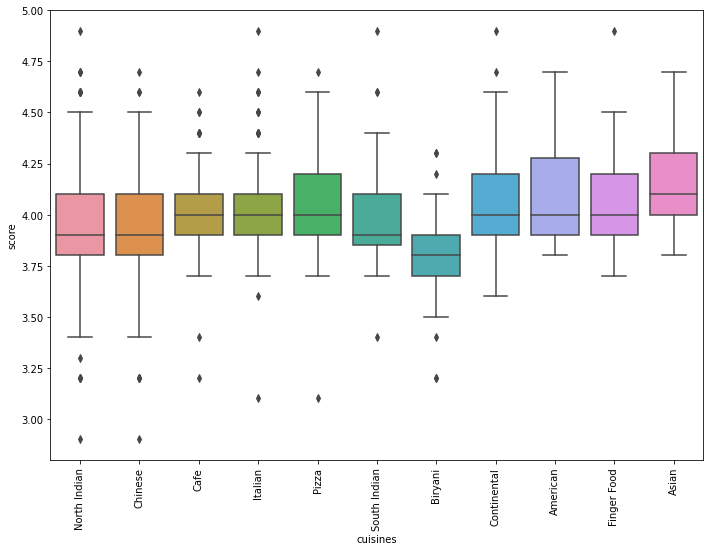

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.boxplot(x="cuisines", y="score", data=q_restaurants_df,ax=ax)
plt.xticks(rotation=90)

In [ ]:
cuisine_groupby = q_restaurants.groupby(['cuisines'])
cuisine_split_mean = cuisine_groupby.mean().reset_index().round(3)
cuisine_split_mean

,cuisines,rate,votes,score
0,Afghan,4.100,1378.333,3.900
1,Afghani,4.100,1875.000,4.000
2,African,4.300,1217.000,4.100
3,American,4.222,2238.038,4.088
4,Andhra,3.973,935.154,3.854
...,...,...,...,...
78,Tea,4.600,2339.000,4.400
79,Tex-Mex,4.400,1196.500,4.200
80,Thai,4.298,1654.000,4.115
81,Tibetan,4.167,707.667,3.933


In [ ]:
cuisine_split_mean.loc[cuisine_split_mean['cuisines'] == 'North Indian']

,cuisines,rate,votes,score
59,North Indian,4.121,1455.275,3.979


In [ ]:
q_restaurants.loc[q_restaurants['cuisines'] == 'African']

,cuisines,rate,votes,score
5146,African,4.3,1217,4.1
